# K Means Clustering

## Import Libraries

** Import the libraries you usually use for data analysis.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

** Read in the College_Data file using read_csv. Figure out how to set the first column as the index.**

In [2]:
df = pd.read_csv('./clean_data/adult_train.txt',index_col=False)
#df.head()
#df.info()
#df.describe()
#g = sns.FacetGrid(df,hue="income",palette="Set1",size=5,aspect=1.6)
#g = g.map(plt.hist,'age',bins=20,alpha=0.7)
#g = sns.FacetGrid(df,hue="sex",palette="Set1",size=5,aspect=1.6)
#g = g.map(plt.hist,'hr_per_week',bins=20,alpha=0.7)

## K Means Cluster Creation

** Import KMeans from SciKit Learn.**

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report

In [4]:
kmeans = KMeans(n_clusters=2, random_state=111)
kmeans.fit(df.drop('income',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [5]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[13959  8695]
 [ 2342  5166]]
             precision    recall  f1-score   support

          0       0.86      0.62      0.72     22654
          1       0.37      0.69      0.48      7508

avg / total       0.74      0.63      0.66     30162



**Let's normalize the Data and apply clustering**

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [8]:
df_norm = pd.DataFrame(scaled_data, columns = df.columns)
df_norm = df_norm.drop('income',axis=1)

In [9]:
kmeans.fit(df_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [10]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[11319 11335]
 [ 1054  6454]]
             precision    recall  f1-score   support

          0       0.91      0.50      0.65     22654
          1       0.36      0.86      0.51      7508

avg / total       0.78      0.59      0.61     30162



### Apply PCA to Normalized Data

In [11]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2)
pca.fit(df_norm)
pca2 = pca.transform(df_norm)

In [27]:
df_norm.shape, pca2.shape

((30162, 11), (30162, 2))

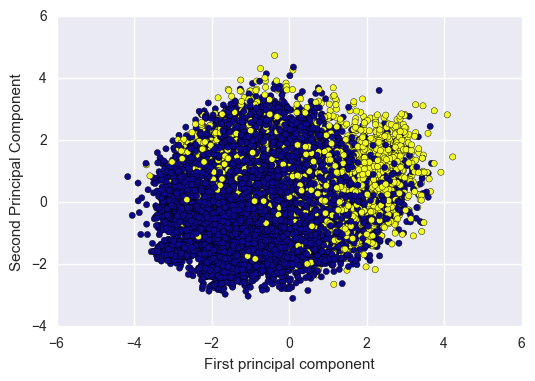

In [28]:
# let's plot it
plt.figure(figsize=(6,4))
plt.scatter(pca2[:,0],pca2[:,1],c=df['income'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [62]:
kmeans.fit(pca2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [63]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[11008 11646]
 [ 6481  1027]]
             precision    recall  f1-score   support

          0       0.63      0.49      0.55     22654
          1       0.08      0.14      0.10      7508

avg / total       0.49      0.40      0.44     30162



### Try 3 Components

In [34]:
from mpl_toolkits.mplot3d import Axes3D

In [35]:
pca = PCA(n_components=3)
pca.fit(df_norm)
pca3 = pca.transform(df_norm)

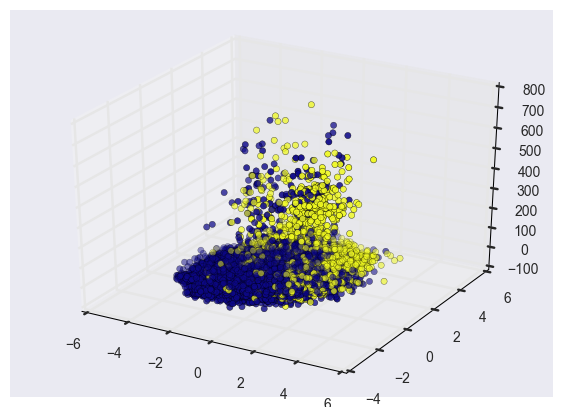

In [61]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3[:,0], pca3[:,1],pca3[:,2]**4,c=df['income'],cmap='plasma')